In [78]:
import xarray
import numpy as np

import matplotlib.pyplot as plt
import scipy
from scipy.spatial import distance

## I

1. create 3 arrays from mw data: value, x and y ( or two with x and y as tuple)
2. crete same size 0 array
3. find not nan indexes and nan indexes.

For each not-nan:

4. get xy

For each nan:

5. get xy
6. find distances and take lowest
7. update zero array. 

In [3]:
mw_path = r"../Data/microwave-rs/mw_interpolated/"
data_mw = xarray.open_dataarray(mw_path + '2019-06-08_mw.tif')

In [4]:
mw_x = data_mw['x'].values
mw_y = data_mw['y'].values
mw_val = data_mw[0].values
zeros = np.zeros(mw_val.shape) # (2663, 1462)

In [5]:
from math import sqrt, pow
from tqdm import tqdm

def find_neighboring_water(arr):
    rows, cols = len(arr), len(arr[0])
    neighboring = []
    for i in tqdm(range(rows)):
        for j in range(cols):
            if arr[i][j] == -1:
                if i > 0 and arr[i-1][j] != -1:
                    neighboring.append((i, j))
                elif i < rows - 1 and arr[i+1][j] != -1:
                    neighboring.append((i, j))
                elif j > 0 and arr[i][j-1] != -1:
                    neighboring.append((i, j))
                elif j < cols - 1 and arr[i][j+1] != -1:
                    neighboring.append((i, j))
    return neighboring

In [6]:
ice_indices = np.argwhere(mw_val != -1)
#masked_indices = np.argwhere(mw_val == -1) # remove all that dont touch land. 
masked_indices = find_neighboring_water(mw_val)

100%|██████████| 2663/2663 [00:24<00:00, 109.70it/s]


In [ ]:
from scipy.spatial import distance

for ii in tqdm(ice_indices):
    y_ice_idx = ii[0] # max index 2662
    x_ice_idx = ii[1]
    x_ice = mw_x[x_ice_idx] # max size 1462
    y_ice = mw_y[y_ice_idx]

    shortest_dist = 999999
    for jj in masked_indices:
        y_masked_idx = jj[0]# should be max 1461 but get 1462 - bc its x
        x_masked_idx = jj[1]
        x_masked = mw_x[x_masked_idx]
        y_masked = mw_y[y_masked_idx]

        dist = distance.euclidean((x_masked, y_masked), (x_ice, y_ice))
        if dist < shortest_dist:
            shortest_dist = dist

    zeros[x_ice_idx, y_ice_idx] = shortest_dist   


## II

1. get two arrays for x and y of closest thing

For each pixel in ice_indices:

2. get indexes
3. get coordinates
4. get indexes of distant pixel
5. get coordinates of distant pixel

In [65]:
mw_path = r"../Data/microwave-rs/mw_interpolated/"
data_mw = xarray.open_dataarray(mw_path + '2019-06-08_mw.tif')

mw_val = data_mw[0].values
# np.isnan(mw_val).sum()

mw_val_masked = np.copy(mw_val)
mw_val_masked[mw_val_masked==1]=0

#np.unique(mw_val_masked)

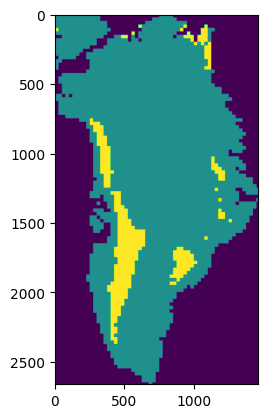

In [71]:
plt.imshow(mw_val)

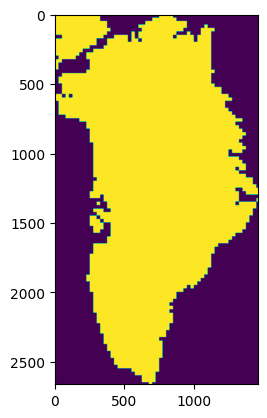

In [73]:
plt.imshow(mw_val_masked)

In [74]:
dist_idx = scipy.ndimage.morphology.distance_transform_edt(mw_val_masked==0, return_distances=False, return_indices=True)

for ii in tqdm(ice_indices):
    ice_idx_x = ii[0] # max index 2662
    ice_idx_y = ii[1]
    ice_coord_x = mw_x[ice_idx_y] # max size 1462
    ice_coord_y = mw_y[ice_idx_x]

    masked_idx_x = dist_idx[0][ice_idx_x, ice_idx_y]
    masked_idx_y = dist_idx[1][ice_idx_x, ice_idx_y] # why is y over 1462?
    masked_coord_x = mw_x[masked_idx_y]
    masked_coord_y = mw_y[masked_idx_x]

    shortest_dist = distance.euclidean((masked_coord_x, masked_coord_y), (ice_coord_x, ice_coord_y))
    zeros[ice_idx_x, ice_idx_y] = shortest_dist   

/tmp/ipykernel_13841/1179813671.py:4: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  dist_idx = scipy.ndimage.morphology.distance_transform_edt(mw_val_masked==0, return_distances=False, return_indices=True)
100%|██████████| 2278725/2278725 [00:21<00:00, 107258.44it/s]


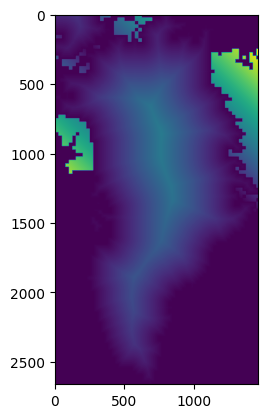

In [75]:
plt.imshow(zeros)

/tmp/ipykernel_13841/1347319268.py:1: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  plt.imshow(scipy.ndimage.morphology.distance_transform_edt(mw_val_masked==0))


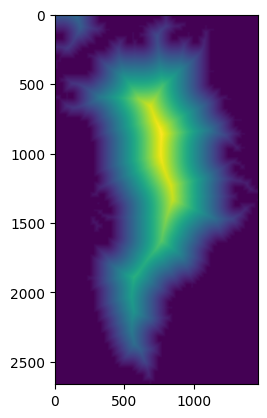

In [81]:
plt.imshow(scipy.ndimage.morphology.distance_transform_edt(mw_val_masked==0))

In [82]:
dist = scipy.ndimage.morphology.distance_transform_edt(mw_val_masked==0)

/tmp/ipykernel_13841/2984090542.py:1: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  dist = scipy.ndimage.morphology.distance_transform_edt(mw_val_masked==0)


In [84]:
dist.shape

(2663, 1462)

In [86]:
import pandas as pd

In [85]:
def convolution_to_df(convolution_raster, column_name):
    nrows, ncols = convolution_raster.shape
    # create an array of x and y positions
    x = np.tile(np.arange(ncols), nrows)
    y = np.repeat(np.arange(nrows), ncols)
    # create a DataFrame with x, y, and pixel values as columns
    df = pd.DataFrame({'col': x, 'row': y, column_name: convolution_raster.flatten()})
    return df 

In [87]:
convolution_to_df(dist, 'distance')

,col,row,distance
0,0,0,150.0
1,1,0,150.0
2,2,0,150.0
3,3,0,150.0
4,4,0,150.0
...,...,...,...
3893301,1457,2662,0.0
3893302,1458,2662,0.0
3893303,1459,2662,0.0
3893304,1460,2662,0.0


## test

In [57]:
a = np.array((
            [ 1, 0,-1,-1,-1,-1,-1,-1],
            [ 0,-1,-1, 0,-1,-1,-1,-1],
            [-1,-1, 0, 1, 0, 0,-1,-1],
            [-1,-1,-1, 1, 1, 0, 0,-1],
            [-1,-1,-1, 0, 1, 0,-1,-1],
            [-1,-1,-1, 0, 0, 0,-1,-1],
            [-1,-1,-1, 0, 0, 1,-1,-1],
            [-1,-1,-1, 1, 0,-1,-1,-1],
            [-1,-1,-1, 0,-1,-1,-1,-1],
            [-1,-1,-1,-1,-1,-1,-1,-1]
            ))

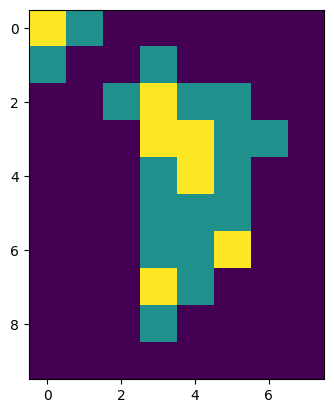

In [58]:
plt.imshow(a)

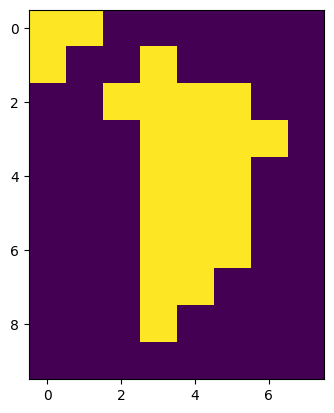

In [60]:
a[a==1]=0
plt.imshow(a)

/tmp/ipykernel_13841/2335709528.py:1: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  plt.imshow(scipy.ndimage.morphology.distance_transform_edt(a==0, return_distances=True, return_indices=False))


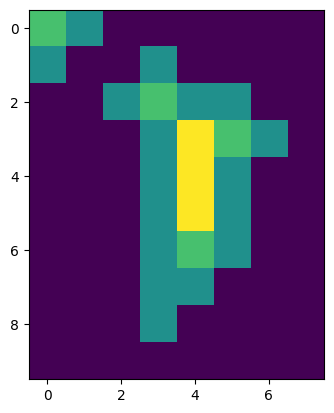

In [70]:
plt.imshow(scipy.ndimage.morphology.distance_transform_edt(a==0, return_distances=True, return_indices=False))

In [ ]:
# test 